# Bundle Adjustment using scipy

### Project 2 - Part B:
Project 2 - Part B is at the end of this notebook. Submission details are also mentioned at the end itself.

Credits: [scipy-cookbook](https://github.com/scipy/scipy-cookbook/blob/master/ipython/bundle_adjustment.ipynb)

This notebook builds on the above scipy tutorial. I have made it more elaborate and explained the code in greater detail, in line with [the theory you've learned in the MR class](https://www.notion.so/saishubodh/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470#6d310735014a429ea623883d607fa978).

### Task
We have a set of points in real world defined by their coordinates $(X, Y, Z)$ in some apriori chosen "world coordinate frame". We photograph these points by different cameras, which are characterized by their orientation and translation relative to the world coordinate frame and also by focal length and two radial distortion parameters (9 parameters in total). Then we precicely measure 2-D coordinates $(x, y)$ of the points projected by the cameras on images. Our task is to refine 3-D coordinates of original points as well as camera parameters, by minimizing the sum of squares of reprojecting errors.

Now let's start solving some real bundle adjusment problem. We'll take a problem from http://grail.cs.washington.edu/projects/bal/.

In [3]:
from __future__ import print_function

In [4]:
import urllib
import bz2
import os
import numpy as np
import open3d as o3d

First download the data file:

In [5]:
BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/"

DATASET_NAME = "ladybug/"
FILE_NAME = "problem-49-7776-pre.txt.bz2"
# FILE_NAME_BIG = "problem-412-52215-pre.txt.bz2"

# DATASET_NAME = "dubrovnik/"
# FILE_NAME = "problem-88-64298-pre.txt.bz2"

URL = BASE_URL + DATASET_NAME + FILE_NAME

In [6]:
if not os.path.isfile(FILE_NAME):
    urllib.request.urlretrieve(URL, FILE_NAME)

Now read the data from the file:

In [7]:
def read_bal_data(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

In [8]:
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data(FILE_NAME)

In [9]:
print(f"camera_params: {camera_params.shape};\npoints_3d: {points_3d.shape};\n"
        f"camera_indices: {camera_indices.shape}; \npoint_indices: {point_indices.shape}; \n"
        f"points_2d: {points_2d.shape}")

camera_params: (49, 9);
points_3d: (7776, 3);
camera_indices: (31843,); 
point_indices: (31843,); 
points_2d: (31843, 2)


Here we have numpy arrays:

1. `camera_params` with shape `(n_cameras, 9)` contains initial estimates of parameters for all cameras. First 3 components in each row form a **rotation vector**, next 3 components form a translation vector, then a focal distance and two distortion parameters.
2. `points_3d` with shape `(n_points, 3)` contains initial estimates of point coordinates in the world frame.
3. `points_2d` with shape `(n_observations, 2)` contains measured 2-D coordinates of points projected on images in all the observations.
4. `camera_ind` with shape `(n_observations,)` gives the index of the camera (from 0 to `n_cameras - 1`) associated with a particular observation.   
    - TODO-for-students: Basics - How do we know this (`camera_ind`) information in practical setting? Explain.     
5. `point_ind` with shape `(n_observations,)` contains indices of 3D points (from 0 to `n_points - 1`) involved in each observation.
    - TODO-for-students: Basics - How do we know this (`point_ind`) information in practical setting? Explain.


In [10]:
print(point_indices[:30],"\n",camera_indices[:30])

[0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 
 [ 0  1  3 26 29 36  0  1  4  8 20 38 47  0  1  2  3  4  5  6  7  8  9 10
 11 12 13 15 17 20]


In [11]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]

n = 9 * n_cameras + 3 * n_points
m = 2 * points_2d.shape[0]

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters to estimate: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 49
n_points: 7776
Total number of parameters to estimate: 23769
Total number of residuals: 63686


We chose a relatively small problem to reduce computation time, but scipy's algorithm is capable of solving much larger problems, although required time will grow proportionally.

Now define the function which returns a vector of residuals. We use numpy vectorized computations:

In [12]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis] #np.newaxis converts this into a column vector.
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return (cos_theta * points) + ((1 - cos_theta) * v * dot) + (sin_theta * np.cross(v, points))

### A short review on Transformations

Rodrigues Formula: $$\mathbf{R}=\cos \theta \mathbf{I}+(1-\cos \theta) \mathbf{n n}^{\mathrm{T}}+\sin \theta \mathbf{n}^{\wedge}$$
If described by a rotation vector, assuming that the rotation axis is a unit length vector $\mathbf{n}$ and the angle is $\theta$, then the vector $\theta \mathbf{n}$ can also describe this rotation. Here, rot_vecs = $\theta \mathbf{n}$.

In [13]:
# points_pro = points_3d[:, :2] / points_3d[:, 2, np.newaxis]
# points_pro.shape

In [14]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:6]
    # TODO-for-students: Transformations - project() function:
    # In the project() function, would it make any difference if I do translate first, then rotate? Why/why not?
    points_proj = -points_proj[:, :2] / points_proj[:, 2, np.newaxis]
    f = camera_params[:, 6]
    k1 = camera_params[:, 7]
    k2 = camera_params[:, 8]
    n = np.sum(points_proj**2, axis=1) #n = (r_c)^2
    r = 1 + k1 * n + k2 * n**2
    points_proj *= (r * f)[:, np.newaxis]
    return points_proj

## A short review on camera modelling & radial distortion



- Each pixel moves radially away from (barrel) or towards (pincushion) the image center (c).
- As a function of distance from $c: r_{c}^{2}=x_{c}^{2}+y_{c}^{2}$.
- In code, $n = r_{c}^{2}$
- The shift $\gamma$ can be modelled as: $\gamma=1+k_{1} r_{c}^{2}+k_{2} r_{c}^{4}$ where ${k}_{1}$ and ${k}_{2}$ are radial distortion parameters.
- The modified co-ordinates are:

$$\begin{array}{l}
\hat{x}_{c}=\gamma x_{c} \\
\hat{y}_{c}=\gamma y_{c}
\end{array} 
$$

- **This is applied before the focal-length multiplier and center shift are applied**: Meaning before $K$ matrix is even applied. But how do we exactly do that?

    $$\mathbf{K}=\left[\begin{array}{ccc}\alpha_{x} & 0 & x_{0} \\0 & \alpha_{y} & y_{0} \\0 & 0 & 1\end{array}\right] ; \qquad      \lambda {p} = \mathrm{x} =K[R \quad t] \mathrm{X}$$

    $$x_{final} = \gamma \left(\frac{f_0X}{Z}+c_x \right)
     \qquad \color{red} \bigotimes \textbf{wrong}$$

    $$x_{final} =  \left(f_0 \left(\gamma\frac{X}{Z} \right)+c_x \right)
     \qquad \color{surd} \checkmark \textbf{correct}$$

### Summing it up
Let $\pmb{P} = (X, Y, Z)^T$ - a radius-vector of a point, $\pmb{R}$ - a rotation matrix of a camera, $\pmb{t}$ - a translation vector of a camera, $f$ - its focal distance, $k_1, k_2$ - its distortion parameters. Then the reprojecting is done as follows:

\begin{align}
\pmb{Q} = \pmb{R} \pmb{P} + \pmb{t} \\
\pmb{q} = -\begin{pmatrix} Q_x / Q_z \\ Q_y / Q_z \end{pmatrix} \\
\pmb{p} = f (1 + k_1 \lVert \pmb{q} \rVert^2 + k_2 \lVert \pmb{q} \rVert^4) \pmb{q}
\end{align}
The resulting vector $\pmb{p}=(x, y)^T$ contains image coordinates of the original point.
![radial_distortion_1.png](./misc/radial_distortion_1.png) 
![radial_distortion_2.png](./misc/radial_distortion_2.png)

In [15]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

## A short review on Structure from Motion
### Residual
In our lecture, in the residual vector, we nicely wrote the elements in order: 11, 12, 13.., 1N, then 21, 22.. and so on till MN. However, notice that it is not the case here.

In [16]:
# print(points_2d[:5], camera_indices[:5], point_indices[:5])

M -> camera, N -> 3D point (in our lectures, NOT in this code)
![sfm_residual_1.png](./misc/sfm_residual_1.png)

You can see that computing Jacobian of `fun` is cumbersome, thus we will rely on the finite difference approximation. To make this process time feasible we provide Jacobian sparsity structure (i. e. mark elements which are known to be non-zero):

![sfm_jac_2.png](./misc/sfm_jac_2.png)

In [17]:
from scipy.sparse import lil_matrix

In [18]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2 
    #TODO-for-students: Jacobian - bundle_adjustment_sparsity() function:
    # m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    
    n = n_cameras * 9 + n_points * 3 
    #TODO-for-students: Jacobian & Parameters - bundle_adjustment_sparsity() function:
    # 1. Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`?  Recollect :Every
    # individual motion Jacobian was (1*)12 in our lecture notes.
    # 2. Ignoring the scale parameters, what was the number of unknown parameters
    # in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in 
    # the code? Is it different? If so, what is and why? Link of notes : https://www.notion.so/saishubodh/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470#6208437ceaaa47f49cfa0ad736de982a
    
    
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1
    
    # TODO-for-students: Sparsity, Residual Vector & Jacobian - bundle_adjustment_sparsity() function:
    # Explain what you understand from above 6 lines of code by coding a 
    # simple toy example yourself to illustrate how it is different from what you've learnt in class.
    # ([Coding toy example + elaborating in words]- both are compulsory.)
        
    return A

### THAT'S IT! Now we are ready to use inbuilt library functions!
Now we are ready to run optimization. Let's visualize residuals evaluated with the initial parameters.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

In [20]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

In [21]:
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

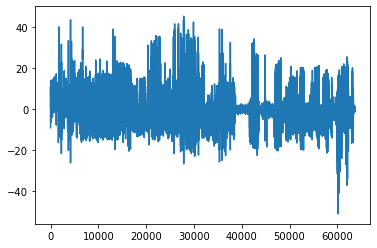

In [22]:
plt.plot(f0)

In [23]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)

In [24]:
import time
from scipy.optimize import least_squares

In [25]:
t0 = time.time()
# So far: method='lm'
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5091e+05                                    8.57e+06    
       1              3         5.0985e+04      8.00e+05       1.46e+02       1.15e+06    
       2              4         1.6077e+04      3.49e+04       2.59e+01       2.43e+05    
       3              5         1.4163e+04      1.91e+03       2.86e+02       1.21e+05    
       4              7         1.3695e+04      4.67e+02       1.32e+02       2.51e+04    
       5              8         1.3481e+04      2.14e+02       2.24e+02       1.54e+04    
       6              9         1.3436e+04      4.55e+01       3.18e+02       2.73e+04    
       7             10         1.3422e+04      1.37e+01       6.81e+01       2.19e+03    
       8             11         1.3418e+04      3.70e+00       1.29e+02       7.96e+03    
       9             12         1.3414e+04      4.23e+00       2.64e+01       6.19e+02    

Setting `scaling='jac'` was done to automatically scale the variables and equalize their influence on the cost function (clearly the camera parameters and coordinates of the points are very different entities). This option turned out to be crucial for successfull bundle adjustment.

In [26]:
print("Optimization took {0:.0f} seconds".format(t1 - t0))

Optimization took 22 seconds


Now let's plot residuals at the found solution:

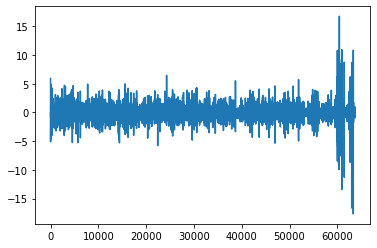

In [27]:
plt.plot(res.fun)

We see much better picture of residuals now, with the mean being very close to zero. There are some spikes left. It can be explained by outliers in the data, or, possibly, the algorithm found a local minimum (very good one though) or didn't converged enough. Note that the algorithm worked with Jacobian finite difference aproximate, which can potentially block the progress near the minimum because of insufficient accuracy (but again, computing exact Jacobian for this problem is quite difficult).

### Project 2- Part B: Submission details -
You are supposed to gain understanding by playing around with the code above and submit your answers to questions asked below. You shouldn't submit this whole notebook, just copy the following cells (starting next cell up until the end of this notebook) and paste it at the end of your Project 2 notebook (already shared on GitHub classrooms, [link](https://github.com/AryanSakaria/Project_2/blob/main/Project_2.ipynb)).

# Project 2 - Part B:

## 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - Ans-1 - Basics:
        * We know the ordering of camera views and are able to extract features from the same. 
        * This ordering of camera views along with the ordering of poses (which are also known) allows us to generate the array 'camera_ind'

        
        
2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - Ans-2 - Basics:
        * We use feature extraction algorithms such as SIFT (Scale-Invarient-Feature-Transform) and SURF (Speeded-Up Robust Feature) extraction to find noteable features such as a sharp edge in an image.
        * We look to find the corresponding feature in another image plane. We then end up with a stereopair which has 2d-2d correspondances. 
        * The depth is estimated via triangulation, as the extrinsics as well as the intrinsics of the camera's are known, we can accurately recover the 3d world point.

   
   
3. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - Ans-3 - Transformations:
        * Yes, It will make a difference. The order of these operations is not permutable.
        * Our translation and rotations are described according to a certain coordinate frame. If the translation is done first then the rotation will yeild a different result to the one we would get if we rotated first and then translated.
        * In order to obrain the same results by translating first and then rotating, the rotation center has to be translated by the same translation vector.
        
        
4. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - Ans-4 - Jacobian:
        * In the in-class discussions and lecture notes, m denotes the number of poses, that is, the number of views. 'n' denotes the number of points obtained from each view.
        * In accordance to the above convention, we would get m*n*2(one for x, one for y) equations. This is the total number of observed 2d points captured in the process.
        * Here, the points obtained from each image isn't fixed like we had in class (or in the notion page). We are given total number of points rather than the points per pose.
5. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes. 
        - Answer to 5A - Jacobian & Parameters:
            * The reason for multiplying by 9 here and not 12 as discussed in class stems from what that number signifies.
            * The reason for having n_cameras * 12 in the lecture notes is that we are solving for all 12 values of the projection matrix P which has dimensions 3x4.
            * The reduction in parameters is down to working with the axis angle rotation convention which has just 6 parameters. The number of camera parameters is 3, one for the focal length and two for the distortion parameters along x and y.
    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        - Ans 5.2 - Jacobian & Parameters:
            * Ignoring the scale factors, the number of unknown parameters solved for in class is as mentioned above where n_points is computed as the number of poses times the number of points observed in each view divided by the number of times each point is seen.
            * The number of unknowns in the above code is (n_cameras * 9 + n_points * 3). The 9 comes from the new number of parameters to solve for in every pose. n_cameras and n_points are known a priori thus resulting in a different number of solvable parameters.

6. `2 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.)
    - Ans 6 - Sparsity, Residual Vector & Jacobian:
        - The above code not only is a new implementation but changes the structure of the Jacobian itself. On analysis of the above code blocks, we can say:
        - The structure of the jacobian is observed to be sparse. The above code aims to populate a spare matrix which dictates the sparsity of the jacobian. The above implementation sets the non-zero entries to 1. This sparsity in the structure of the jacobian is something that is wanted to be exploited when performing computations. The scipy function leverages this fact for us and speeds up the computation.
        - If the number of unknown parameters is given by 'n' and 'm' gives the total number of points, the size of the jacobian as well as the size of the residual can be computed. 
        - The jacobian is of size (2m, n) it has non zero entries only for the parameters that are used in the computation of a specific point in a specific image.
        - The size of the residual is: 2m
        

In [28]:
camera_ind_exp = 10
m = camera_ind_exp * 2
B = np.zeros([m,16])
i = np.arange(camera_ind_exp)

practical = True
# theoretical setting
if practical == False:
    B[2*i, np.array([0,0,0,0,0,  1,1,1,1,1])]=1
    B[2*i + 1, np.array([0,0,0,0,0,  1,1,1,1,1])]=1
# practical setting
else:
    B[2*i, np.array([0,2,5,6,2,  1,9,14,7,11])]=1
    B[2*i + 1, np.array([0,2,5,6,2,  1,9,14,7,11])]=1


B

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,

## 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers). A sample answer could be as follows:

**Ans 2:**

1. **Feature mapping** <br>

* We use `cv2.SIFT_create()` to create a SIFT based feature detector.
*  We then get SIFT features which are keypoints and descriptors using `kp, desc = sift.detectAndCompute(img, mask=None)` for both images as (kp1, desc1) and (kp2, desc2)

2.  **Find correspondences from features** <br>
To find correspondences from features we find matching features using a knn based feature matcher. The steps for it are as follows: 

* We use `cv2.FlannBasedMatcher()` to create a FLANN, with initializion of search =  50 checks and kdtree = 5 trees.
* We then use `matches = flann.knnMatch(desc1, desc2, k=2)` to apply a flann matcher with k=2(since correspondences between 2 images).
* Now we can get good matches of the 2 nearest neighbors which are p1 and p2 using ratio test.

3. **Find fundamental matrix** <br> 
Now, we find fundamental matrix $F$ using 
`F, mask = cv2.findFundamentalMat(p1,p2,cv2.FM_LMEDS)`.

4. **Get essential matrix E**  <br>
Essential matrix can be calculated as follows since F and k are known.
 $F=K^{-T}EK^{-1}$
 
5. **Decompose E to R, t** <br>
 Essential matrix $E$ can be decomposed into $R$, $t$ with:
    - `retval, R, t, mask = cv2.recoverPose(E, p1, p2, K)`
    where  $E$ is Essential matrix, $K$ matrix and p1, p2 are the corresponding points in two images.
    
6. **Use triangulation to initialize the 3d points for SfM** <br>
Now, we use triangulation to find the position of 3d points and initialise them for the LM/GN in bundle adjustment problem/Sfm. (since the camera matrix $K$, point correspondences in the two images (p1 and p2), relative position of camera centers using $R$ and $t$ were known)
